# Application : **Débruitage d'images avec des autoencodeurs**

## Importation de TensorFlow et d'autres bibliothèques

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Importer le jeu de données
Pour débuter, nous allons entraîner l'autoencodeur en utilisant le jeu de données Fashion MNIST. Chaque image dans ce jeu de données a une résolution de 28x28 pixels.

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.  #pour la normalisation
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


Un autoencodeur peut être entraîné pour éliminer le bruit des images. Dans la section suivante, nous  allons  créer une version bruyante du jeu de données Fashion MNIST en appliquant un bruit aléatoire à chaque image. Ensuite, nous entraînerons un autoencodeur en utilisant l'image bruyante en tant qu'entrée et l'image d'origine comme cible.



Ajout de bruit aléatoire aux images

In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

affichons les images bruyantes.

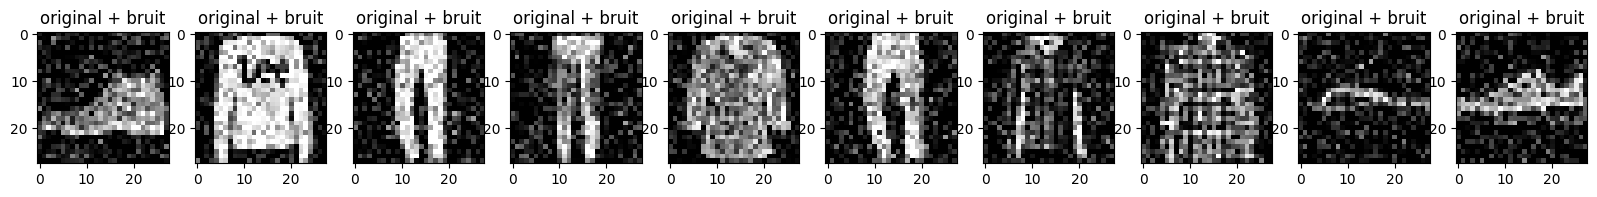

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + bruit")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Définir un autoencodeur convolutionnel
Dans cet exemple, nous allons entraîner un autoencodeur convolutionnel en utilisant des couches Conv2D dans l'encodeur et des couches Conv2DTranspose dans le décodeur.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [8]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=10,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))


Epoch 1/10
1875/1875 [==============================] - 87s 46ms/step - loss: 0.0171 - val_loss: 0.0108
Epoch 2/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 3/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 4/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 5/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 6/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 7/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 10/10
1875/1875 [==============================] - 76s 41m

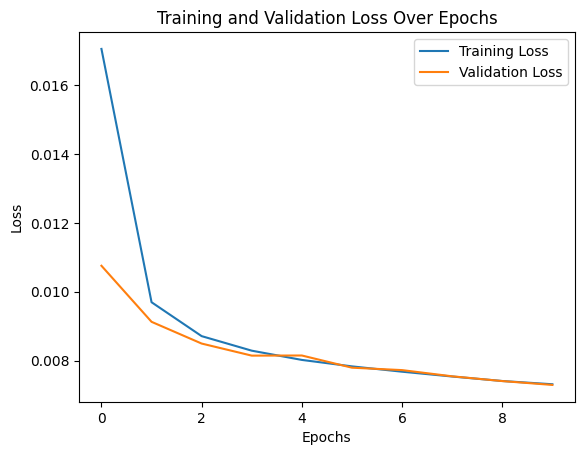

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Jetons un coup d'œil à un résumé de l'encodeur. Remarquez comment les images sont sous-échantillonnées de 28x28 à 7x7.

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


afficher  à la fois les images bruyantes et les images débruitées produites par l'autoencodeur.

In [10]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

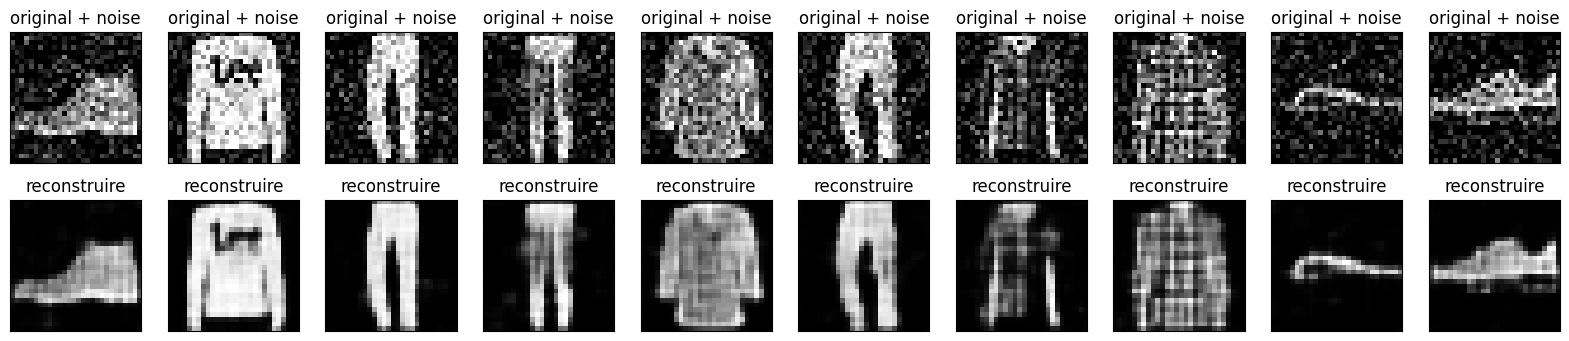

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # affichage original + bruit
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # affichage reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstruire")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()